# Basic depiction of a FEP workflow using BioSimSpace and Python

In [55]:
import BioSimSpace as BSS
import glob
from IPython.display import Image
import networkx # 2.3!
import csv

BSS.__version__

'2020.1.0+237.g07579c3'

## 1. Load ligands and protein into memory.

Loading ligands and protein structures can be done using BSS API.

In [56]:
path_to_protein = "inputs/protein/ROS1"
path_to_ligands = "inputs/ligands/"


# load the protein.
protein = BSS.IO.readMolecules([path_to_protein+".rst7", path_to_protein+".prm7"])[0]

# loading all the ligands is a bit more involved. The simplest way is include a text file with ligand names 
# and loop over it, loading files on the go.
ligands_dict = {}

with open(path_to_ligands+"ligands.csv", "r") as ligand_names_file:
    # easily read csv files with csv module.
    reader = csv.reader(ligand_names_file)
    for ligand_name in reader:
        
        # grab the ligand name as a string instead of a list.
        ligand_name = ligand_name[0]
        
        # make an entry in our dictionary with the ligand name and the loaded molecule.
        ligands_dict[ligand_name] = BSS.IO.readMolecules([
                                                        path_to_ligands+ligand_name+".rst7",
                                                        path_to_ligands+ligand_name+".prm7",
                                                         ])[0]       


## 3. Determine which edges to run using LOMAP.


We'll use LOMAP to pick edges between our ligands. There are several ways to run LOMAP through python, but the simplest option is to use the commandline:
  

In [57]:
%%bash
python lomap_networkgen.py inputs/ligands/ -n outputs/lomap/out -v off

We'll define a function that takes the LOMAP output and plots a simple network for us using networkx. 

In [58]:
def plotLOMAP(ligands_path, lomap_output_path):
    """Example function to plot a LOMAP network given a folder with ligand SDF files and the corresponding
    LOMAP-generated edges file with scores."""
    
    import matplotlib.pyplot as plt # 2.2.3!
    plt.rcParams['figure.dpi']= 150
    import matplotlib.image as mpimg
    import numpy as np
    import networkx as nx # 2.3!
    # based mainly on https://stackoverflow.com/questions/53967392/creating-a-graph-with-images-as-nodes

    #RDKit imports
    from rdkit import Chem
    from rdkit.Chem import rdFMCS, AllChem, Draw

    from rdkit import RDLogger
    RDLogger.DisableLog('rdApp.*')

    lomap_nodes = []
    lomap_edges = []
    lomap_scores = {}

    with open(lomap_output_path, "r") as edges_file:
        reader = csv.reader(edges_file)
        for row in reader:

            # the file contains all possible edges. Take only edges which LOMAP indicates should be drawn.
            if row[7] == "Yes       ":

                # we need to extract some knowledge about this edge.
                node1 = row[2].rsplit(".")[0]
                node2 = row[3].rsplit(".")[0]
                lomap_score = row[4]

                # append to lists/dict.
                # follow ~ this example: https://stackoverflow.com/questions/47094949/labeling-edges-in-networkx
                lomap_nodes.append(node1)
                lomap_nodes.append(node2)
                lomap_edges.append([node1, node2])
                lomap_scores[(node1, node2)] = round(float(lomap_score), 2)

    lomap_nodes = set(lomap_nodes)
    # to draw molecular structures aligned we need to find the MCS and use that as a template.
    ligs = [ Chem.SDMolSupplier(mol)[0] for mol in glob.glob(ligands_path) ]
    lig_names = [ ligpath.split("/")[-1].split(".sdf")[0] for ligpath in glob.glob(ligands_path) ]

    template = Chem.MolFromSmarts(rdFMCS.FindMCS(ligs).smartsString)
    AllChem.Compute2DCoords(template)

    # load all ligands, make 2D depiction aligned to the template and save to file.
    for lig, lig_name in zip(ligs, lig_names):
        AllChem.Compute2DCoords(lig)
        AllChem.GenerateDepictionMatching2DStructure(lig, template)

        # now save images to files that can be loaded by networkx.
        Draw.MolToFile(lig, "outputs/lomap/"+lig_name+".png")


    ################

    G=nx.Graph()

    for node in lomap_nodes:
        img = mpimg.imread("outputs/lomap/"+node+".png")

        G.add_node(node, image=img)

    for edge in lomap_edges:
        G.add_edge(edge[0],edge[1])


    pos=nx.circular_layout(G)

    fig=plt.figure(figsize=(15,15))
    ax=plt.subplot(111)
    ax.set_aspect('equal')
    nx.draw_networkx_edges(G,pos,ax=ax)
    nx.draw_networkx_edge_labels(G,pos,edge_labels=lomap_scores)

    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)

    trans=ax.transData.transform
    trans2=fig.transFigure.inverted().transform

    piesize=0.15 # this is the image size
    p2=piesize/2.0
    for n, ligand_name in zip(G, pos.keys()):
        xx,yy=trans(pos[n]) # figure coordinates
        xa,ya=trans2((xx,yy)) # axes coordinates
        a = plt.axes([xa-p2,ya-p2, piesize, piesize])
        a.set_aspect('equal')
        a.imshow(G.nodes[n]['image'])
        #label each node using these adjusted coordinates.
        a.text(s=ligand_name, x=xa*2, y=ya)
        a.axis('off')
    ax.axis('off')


    plt.show()
    
    return lomap_edges, lomap_scores

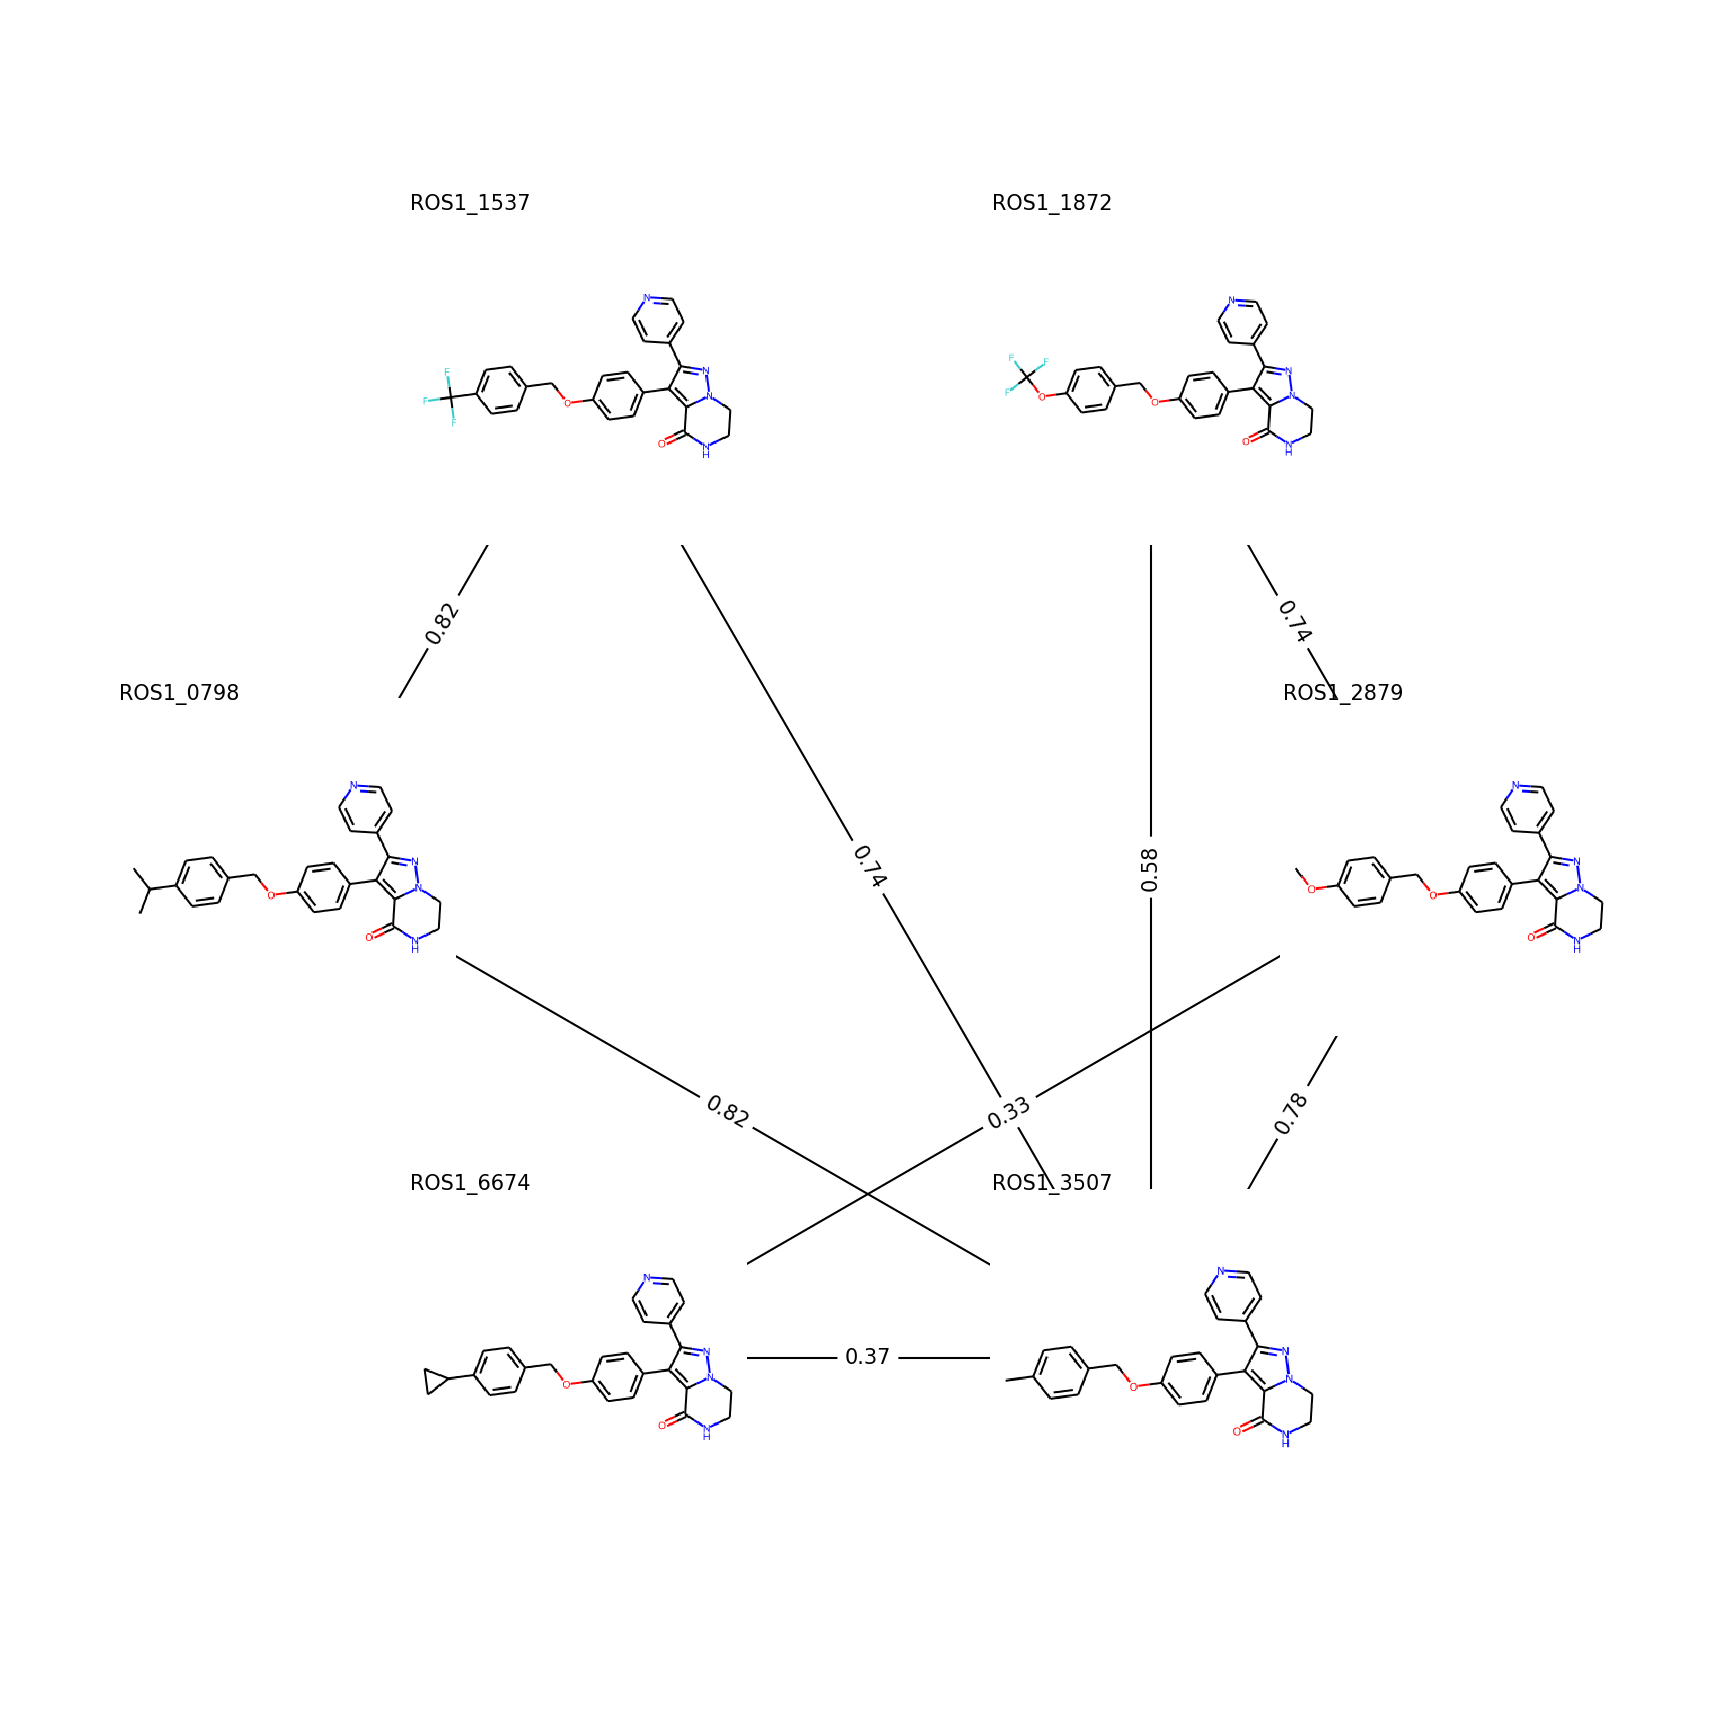

In [59]:
lomap_output_path = "outputs/lomap/out_score_with_connection.txt"
ligands_path = "inputs/ligands/*.sdf"
lomap_edges, lomap_scores = plotLOMAP(ligands_path, lomap_output_path)

We see some low scores (< 0.5) for transformations leading to ROS1_6674. Just to be sure, let's include another edge to this ligand from e.g. ROS1_0798.

In [60]:
lomap_edges.append(['ROS1_0798', 'ROS1_6674'])
lomap_edges

[['ROS1_0798', 'ROS1_1537'],
 ['ROS1_0798', 'ROS1_3507'],
 ['ROS1_1537', 'ROS1_3507'],
 ['ROS1_1872', 'ROS1_2879'],
 ['ROS1_1872', 'ROS1_3507'],
 ['ROS1_2879', 'ROS1_3507'],
 ['ROS1_2879', 'ROS1_6674'],
 ['ROS1_3507', 'ROS1_6674'],
 ['ROS1_0798', 'ROS1_6674']]

## 4. Set up SOMD simulation folders.


In [36]:
# Define the Free Energy protocol. Here we use BSS's standard settings.
# see https://biosimspace.org/api/generated/BioSimSpace.Protocol.FreeEnergy.html#BioSimSpace.Protocol.FreeEnergy 
protocol = BSS.Protocol.FreeEnergy()

In [ ]:
# We can loop over each transformation and do the standard BSS setup protocol.
for pert in lomap_edges:

    
    # get the molecule objects from our dictionary.
    lig_1 = ligands_dict[pert[0]]
    lig_2 = ligands_dict[pert[1]]

    # for each edge we want to run both directions.
    for ligand_A, ligand_B in [
                        [lig_1, lig_2], 
                        [lig_2, lig_1]
                        ]:
        
        # derive the perturbation name (to name our simulation folder).
        pert_name = pert[0]+"~"+pert[1]
    
        # generate a mapping between the two molecules.
        mapping = BSS.Align.matchAtoms(ligand_A, ligand_B)

        # align ligand A to ligand B.
        ligand_A_a = BSS.Align.rmsdAlign(ligand_A, ligand_B, mapping)

        # merge the aligned molecules into a single object.
        merged = BSS.Align.merge(ligand_A_a, ligand_B, mapping,
                                            allow_ring_breaking=True,
                                            allow_ring_size_change=True
                                            )

        # insert the merged molecules into the protein and solvate the system.
        system = protein + merged

        # no GROMACS install on current system; uncomment in tutorial.
        #system = BSS.Solvent.tip3p(molecule=system, box=3*[10*BSS.Units.Length.nanometer])

        # set up a SOMD folder with standard settings.
        # if you want to run replicates here, a simple iteration loop that with work_dir=pert_name+str(i) would work.
        for i in range(3):
            BSS.FreeEnergy.Binding(
                                                    system, 
                                                    protocol, 
                                                    engine="SOMD",
                                                    work_dir="outputs/SOMD/"+pert_name+"_"+str(i)
                                                    )

## 5. Run simulations & gather MBAR results from simulation outputs.

The collection of set up SOMD folders can be run in parallel on e.g. a computing cluster with slurm. An example job script for such a system would like this:

```
#!/bin/bash
#SBATCH --job-name=FEP
#SBATCH -o somd_slurm.out
#SBATCH -p GTX1080
#SBATCH -n 2
#SBATCH --gres=gpu:1

# load modules.
module load cuda/9.2
module load BSS/dev

date
export OPENMM_PLUGIN_DIR=~/biosimspace.app/lib/plugins/

# run all bound lambda folder jobs on the first GPU.
~/biosimspace.app/bin/python run_bss_somd.py bound &

# run all solvated lambda folder jobs on the second GPU. This will finish sooner than the bound jobs, 
# which will free up this GPU for other jobs. I think?
~/biosimspace.app/bin/python run_bss_somd.py free &

# wait untill all jobs are done.
wait

# run MBAR on all this perturbation.
~/biosimspace.app/bin/python run_bss_somd.py mbar &

date
```

The run_bss_somd.py script would look like something along the lines of this:


In [ ]:
#!/bin/python

import BioSimSpace as BSS
import csv
import sys
import os

arg = sys.argv[1]
# get the perturbation name from the path. If nothing 
# was changed this should have been written out by BSS as ligA~ligB.    
pert_name = os.getcwd().split("/")[-1]


if arg == "bound" or arg == "free" or if arg == "vacuum":

    # load the BSS freenrg object associated with this system.
    freenrg = BSS.IO.loadFreenrgObject(".", platform="SOMD")
    
    # run the freenrg object.
    freenrg.run()

elif arg == "mbar":
    
    # load the BSS freenrg object that has the simulations finished.
    freenrg = BSS.IO.loadFreenrgObject(".", platform="SOMD")
    
    pmf_free, pmf_vacuum, free_energy = freenrg.analyse()
    free_energy_diff, free_energy_err = free_energy
    
    # now that we have this value, append it to our summary file.
    with open("../summary.csv", "a") as summaryfile:
        writer = csv.writer(summaryfile)
        writer.writerow([pert_name, free_energy_diff, free_energy_err])

else:
    raise Exception("Please pass any of {} to this script on the "+
                    "commandline.".format(["bound", "free", "vacuum", "mbar"]))

### Some problems with the above:
- we don't want to run vacuum jobs on GPU partitions

- in the current setup does the GPU that finished on solvated actually become available for other jobs?

- replicate MBAR outputs are now being appended line by line. Need to adjust freenrgworkflows (or use an in-between script) to take cross-replicate means. -> there seems to be functionality for this in freenrgworkflows.

- I haven't run any of these edges, so all data from here on is made up. Additionally, I've not been able to find the IC50 values for this set, will have to find the actual values at some point.

## 6. Compute statistics and plot validations.

This can be done outside of this notebook. FreeNrgWorkflows currently generates a new notebook which can be opened to analyse the FEP results. On your cluster or locally, you can run:
```
python run_networkanalysis.py path/to/summary.csv -o path/to/output.dat -e path/to/ic50_exp.dat --stats --generate_notebook
```

See https://github.com/michellab/freenrgworkflows for installation instructions.

### Some issues with output notebook:
- paths in the generated notebook should include a ../ or be full path in order to work.
- For the sake of this tutorial it would be simpler to show the user the code for plotting (for customisation) so I'm going to adjust this. See outputs/freenrg_template.ipynb 